In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import math 
from collections import Counter
import matplotlib.pyplot as plt
from autocorrect import Speller
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from keras.preprocessing.text import Tokenizer
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv('TitleDataSet/final_data.csv', header=None)
df.rename(columns={0: 'comment', 1: 'type'}, inplace=True)

In [3]:
df

,comment,type
0,Love you sir!!,positive
1,Please make videos on..Midpoint circle drawing...,imperative
2,I bought both of your courses on Udemy. You ar...,interrogative
3,"Thank you very much, u really got me in the fi...",positive
4,i hope u are ok with everything going on again...,other
...,...,...
9995,THIS IS GOLD! Absolute peach of a video. But I...,positive
9996,"This is helpful, how to decode a logical conte...",interrogative
9997,wow. reading this slowly actually helped me se...,positive
9998,"Great video sir, really helped a lot.keep goin...",positive


In [4]:
lens = df.comment.str.len()
lens.mean(), lens.std(), lens.max()

(103.4122, 143.00264216694276, 4124)

In [5]:
df.groupby('type').size()

type
imperative       1057
interrogative    3059
negative          482
other            1754
positive         3648
dtype: int64

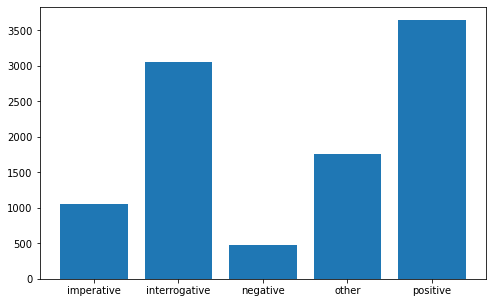

In [6]:
cats = df.groupby('type').size()
y_pos = cats.index
plt.figure(figsize=(8,5))
plt.bar(y_pos, cats.values)
plt.show()

In [7]:
df['comment'] = df['comment'].str.lower()
df['comment'] = df['comment'].str.replace('http\S+|www.\S+', '', case=False)          #url
df['comment'] = df['comment'].str.replace('\n',' ', regex=True)                       #lines
df['comment'] = df['comment'].str.replace('[^\w\s]',' ')                              #punctuations
df['comment'] = df['comment'].str.replace('\d','', regex=True)                        #int
df['comment'] = df['comment'].str.replace('[^\w\s#@/:%.,_-]', ' ', flags=re.UNICODE)  #emoji

C:\Users\ashch\AppData\Local\Temp\ipykernel_4460\2291226569.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['comment'] = df['comment'].str.replace('http\S+|www.\S+', '', case=False)          #url
C:\Users\ashch\AppData\Local\Temp\ipykernel_4460\2291226569.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['comment'] = df['comment'].str.replace('[^\w\s]',' ')                              #punctuations
C:\Users\ashch\AppData\Local\Temp\ipykernel_4460\2291226569.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['comment'] = df['comment'].str.replace('[^\w\s#@/:%.,_-]', ' ', flags=re.UNICODE)  #emoji


In [8]:
df.head()

,comment,type
0,love you sir,positive
1,please make videos on midpoint circle drawing...,imperative
2,i bought both of your courses on udemy you ar...,interrogative
3,thank you very much u really got me in the fi...,positive
4,i hope u are ok with everything going on again...,other


In [9]:
spell = Speller(lang='en')
def typo_corrector(text):
    return spell(text)
df['comment'] = df['comment'].apply(typo_corrector)

In [10]:
stop = stopwords.words('english')
neg = ['no','not']
interrogative = ['how','what','which','who','whom','why','do','does','is','are','was','were','will','am','are','could','would','should','can','did','does','do','had','have']
imperative = ['could','would','should','can']

forNegative = stop.copy()
for word in neg:
    if word in forNegative:
        forNegative.remove(word)
forInterrogative = stop.copy()
for word in interrogative:
    if word in forInterrogative:
        forInterrogative.remove(word)    
forImperative = stop.copy()
for word in imperative:
    if word in forImperative:
        forImperative.remove(word)

for i in range(len(df)):
    if df['type'][i] == "negative":
        df['comment'][i] = ' '.join([word for word in df['comment'][i].split() if word not in forNegative])
for i in range(len(df)):
    if df['type'][i] == "interrogative":
        df['comment'][i] = ' '.join([word for word in df['comment'][i].split() if word not in forInterrogative])
for i in range(len(df)):
    if df['type'][i] == "imperative":
        df['comment'][i] = ' '.join([word for word in df['comment'][i].split() if word not in forImperative])
for i in range(len(df)):
    if df['type'][i] == "positive" or df['type'][i] == "other":
        df['comment'][i] = ' '.join([word for word in df['comment'][i].split() if word not in stop])

In [11]:
lemmatizer = nltk.stem.WordNetLemmatizer()
df['comment'] = df['comment'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

In [12]:
df.head()

,comment,type
0,love sir,positive
1,please make video midpoint circle drawing bres...,imperative
2,bought course dmy are talented teacher keep pr...,interrogative
3,thank much u really got first video algorithm ...,positive
4,hope u ok everything going muslim index,other


In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.comment, df.type, test_size=0.2, random_state=42)

In [14]:
X_train

9254                  sir please tell hr v marketing best
1561                                                     
1670                                      wtf wrong mouse
6087              clear concise explanation thanks dubbed
6669                                            great job
                              ...                        
5734                                       worth watching
5191                                               thanks
5390                                           thank much
860     sir pnzz make video shortest uncommon subseque...
7270    machine learning is like how train subconsciou...
Name: comment, Length: 8000, dtype: object

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=False, min_df=5, norm='l2', ngram_range=(1, 2))
X_train_features = tfidf.fit_transform(X_train)
X_test_features = tfidf.transform(X_test)

In [16]:
X_train_features.shape

(8000, 3141)

In [17]:
X_test_features.shape

(2000, 3141)

In [18]:
mnb = MultinomialNB(alpha=1, fit_prior=False)
mnb.fit(X_train_features, y_train)
predictionsMnb = mnb.predict(X_test_features)

In [19]:
print("MultinomialNB Results: \n")
print(classification_report(y_test,predictionsMnb))

MultinomialNB Results: 

               precision    recall  f1-score   support

   imperative       0.51      0.60      0.55       220
interrogative       0.86      0.90      0.88       623
     negative       0.60      0.46      0.52       112
        other       0.61      0.53      0.57       349
     positive       0.86      0.87      0.87       696

     accuracy                           0.77      2000
    macro avg       0.69      0.67      0.68      2000
 weighted avg       0.76      0.77      0.76      2000



In [20]:
accuracyMnb = accuracy_score(y_test, predictionsMnb)
print("Accuracy: %.2f%%" % (accuracyMnb * 100.0))

Accuracy: 76.70%


In [21]:
svcc = SVC(C=10, gamma='scale', kernel='linear', random_state=0)
svcc.fit(X_train_features, y_train)
predictionsSvc = svcc.predict(X_test_features)

In [22]:
print("Support Vector Classification Results: \n")
print(classification_report(y_test,predictionsSvc))

Support Vector Classification Results: 

               precision    recall  f1-score   support

   imperative       0.60      0.62      0.61       220
interrogative       0.94      0.91      0.92       623
     negative       0.62      0.52      0.57       112
        other       0.60      0.68      0.64       349
     positive       0.85      0.83      0.84       696

     accuracy                           0.79      2000
    macro avg       0.72      0.71      0.71      2000
 weighted avg       0.79      0.79      0.79      2000



In [23]:
accuracySvc = accuracy_score(y_test, predictionsSvc)
print("Accuracy: %.2f%%" % (accuracySvc * 100.0))

Accuracy: 78.70%


In [24]:
lr = LogisticRegression(C=10, penalty='l2', solver='liblinear',random_state=0)
lr.fit(X_train_features, y_train)
predictionsLr = lr.predict(X_test_features)

In [25]:
print("Logistic Regression Results: \n")
print(classification_report(y_test,predictionsLr))

Logistic Regression Results: 

               precision    recall  f1-score   support

   imperative       0.76      0.63      0.69       220
interrogative       0.97      0.94      0.95       623
     negative       0.82      0.49      0.61       112
        other       0.62      0.73      0.67       349
     positive       0.84      0.89      0.87       696

     accuracy                           0.83      2000
    macro avg       0.80      0.74      0.76      2000
 weighted avg       0.83      0.83      0.83      2000



In [26]:
rf = RandomForestClassifier(max_features='log2', n_estimators=1000, criterion = 'entropy', random_state = 0)
rf.fit(X_train_features, y_train)
predictionsR = rf.predict(X_test_features)

In [27]:
print("Random Forest Classifier Results: \n")
print(classification_report(y_test,predictionsR))

Random Forest Classifier Results: 

               precision    recall  f1-score   support

   imperative       0.87      0.52      0.65       220
interrogative       0.89      0.95      0.92       623
     negative       0.90      0.32      0.47       112
        other       0.65      0.75      0.70       349
     positive       0.83      0.90      0.86       696

     accuracy                           0.82      2000
    macro avg       0.83      0.69      0.72      2000
 weighted avg       0.82      0.82      0.81      2000



In [28]:
accuracyR = accuracy_score(y_test, predictionsR)
print("Accuracy: %.2f%%" % (accuracyR * 100.0))

Accuracy: 81.55%


In [34]:
X_train_features.shape[0]

8000

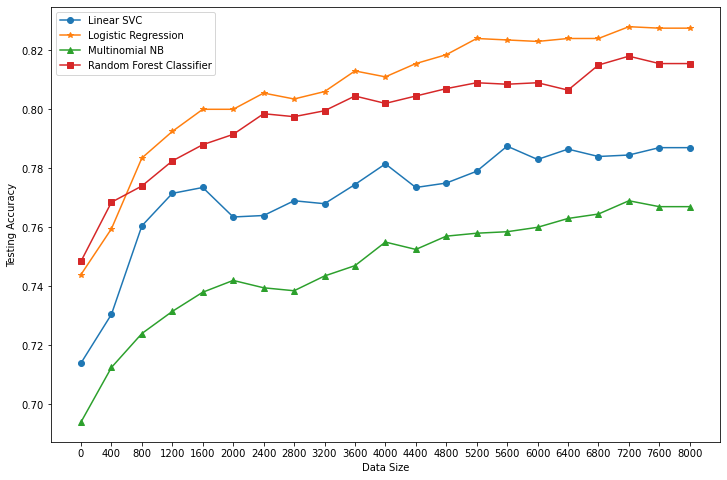

In [35]:
def plot_acc_curve(classifier, linestyle, label):    
    
    num_of_splits = 20
    each_split_size = X_train_features.shape[0]//num_of_splits

    each_split = 400
    scores = []

    for i in range(num_of_splits+1):
        split_X_train = X_train_features[0:each_split]
        split_y_train = y_train[0:each_split]

        each_split += each_split_size

        classifier.fit(split_X_train, split_y_train)
        scores.append(classifier.score(X_test_features, y_test))
    
    m = 20
    n = 400
    x_splits = list(range(0, (m+1)*n, n))

    plt.xlabel('Data Size')
    plt.ylabel('Testing Accuracy')
    plt.plot(x_splits, scores, linestyle, label = label)
    plt.xticks(x_splits)
    plt.legend(loc="best")
    
    return plt
    

plt.figure(figsize=(12,8))

plot_acc_curve(svcc, linestyle = 'o-', label="Linear SVC")

plot_acc_curve(lr, linestyle = '*-', label="Logistic Regression")

plot_acc_curve(mnb, linestyle = '^-', label="Multinomial NB")

plot_acc_curve(rf, linestyle = 's-', label="Random Forest Classifier")

plt.show()

In [29]:
import pickle

In [22]:
with open("Commenttifdf.pkl", 'wb') as handle:
    pickle.dump(tfidf, handle)

In [23]:
pickle.dump(lr, open("CommentModel.pkl", 'wb'))

In [24]:
example = pd.read_csv('vLS-zRCHo-Y.csv', header=None)

In [25]:
example[0] = example[0].str.lower()
example[0] = example[0].str.replace('http\S+|www.\S+', '', case=False)          #url
example[0] = example[0].str.replace('\n',' ', regex=True)                       #lines
example[0] = example[0].str.replace('[^\w\s]',' ')                              #punctuations
example[0] = example[0].str.replace('\d','', regex=True)                        #int
example[0] = example[0].str.replace('[^\w\s#@/:%.,_-]', ' ', flags=re.UNICODE)  #emoji

C:\Users\ashch\AppData\Local\Temp\ipykernel_17456\2697531626.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  example[0] = example[0].str.replace('http\S+|www.\S+', '', case=False)          #url
C:\Users\ashch\AppData\Local\Temp\ipykernel_17456\2697531626.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  example[0] = example[0].str.replace('[^\w\s]',' ')                              #punctuations
C:\Users\ashch\AppData\Local\Temp\ipykernel_17456\2697531626.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  example[0] = example[0].str.replace('[^\w\s#@/:%.,_-]', ' ', flags=re.UNICODE)  #emoji


In [26]:
example[0] = example[0].apply(typo_corrector)

In [27]:
example[0] = example[0].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

In [28]:
features1 = tfidf.transform(example[0])
features1.shape

(219, 3141)

In [29]:
example['predictionsEx'] = lr.predict(features1)

In [33]:
example = example.sort_values(by=['predictionsEx'])

In [34]:
example.to_csv('file2.csv')